In [1]:
import os
from tqdm.auto import tqdm
%load_ext autoreload
%autoreload 2
from helpers import get_df_from_logdir
import pandas as pd
import networkx as nx
import plotly.express as px
import numpy as np
import json
from matplotlib import pyplot as plt
from causal_util.helpers import unpickle

pd.set_option('display.max_columns', None)

In [2]:
# /home/sergei/ray_results/rl_const_sparsity_obs_space_env_sm5_linear_with_lagrange_dual_sparsity_gridsearch_eye_coeff
config_name = 'rl_const_sparsity_obs_space_env_sm5_linear_with_lagrange_dual_sparsity_per_component_gridsearch_eye_coeff'
path = f"/home/sergei/ray_results/{config_name}/"
trials = os.listdir(path)
trials = [os.path.join(path, trial) for trial in trials]
trials = sorted(filter(os.path.isdir, trials))
print(f"Got {len(trials)} trials")

Got 21 trials


# Reading trial data

In [3]:
def get_all_epochs(trial):
    try:
        df = get_df_from_logdir(trial, do_tqdm=False)
    except FileNotFoundError:
        return None
    except json.JSONDecodeError:
        return None
    
    return df

In [4]:
dfs = {trial: get_all_epochs(trial) for trial in tqdm(trials)}

In [6]:
df = list(dfs.values())[0]

In [7]:
data = [df[~pd.isna(df.epochs)].iloc[-1] for df in dfs.values() if hasattr(df, 'epochs')]

In [8]:
df = pd.DataFrame(data)

In [9]:
df.to_csv('sm5_linear_lagrange_per_component.csv', index=False)

In [10]:
df = pd.read_csv('sm5_linear_lagrange_per_component.csv')

In [11]:
list(df.columns)

['epochs',
 'n_samples',
 'losses/opt1d/primal/coeff',
 'losses/opt1d/primal/value',
 'losses/opt1d/value',
 'losses/opt2/dual/coeff',
 'losses/opt2/dual/value',
 'losses/opt2/value',
 'grads/opt1d/grad_total_l1mean',
 'grads/opt1d/grad_total_l2sum',
 'grads/opt2/grad_total_l1mean',
 'grads/opt2/grad_total_l2sum',
 'metrics/batch_index',
 'metrics/batch_size',
 'metrics/primal/fit/value',
 'metrics/primal/fit/coeff',
 'metrics/primal/fit/mean_feature',
 'metrics/primal/fit/std_feature',
 'metrics/primal/fit/min_feature',
 'metrics/primal/fit/max_feature',
 'metrics/primal/fit/loss_fcons',
 'metrics/primal/fit/loss_add',
 'metrics/primal/fit/loss_rec',
 'metrics/primal/fit/loss_fcons_pre',
 'metrics/primal/fit/rec_fit_acc_loss_01_agg',
 'metrics/primal/fit/loss_discrete',
 'metrics/primal/fit/loss_orig',
 'metrics/primal/fit/additional/value',
 'metrics/primal/fit/obs/value',
 'metrics/primal/fit/feat/value',
 'metrics/primal/fit/feat_model/value',
 'metrics/primal/fit/additional_orig/v

In [12]:
# plot_bar('epochs')
plt.rcParams.update({
    #'font.size': 8,
    'text.usetex': False,
#     'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family' : 'normal',
        'font.weight' : 'normal',
        'font.size'   : 20
})


(array([8., 0., 2., 2., 1., 1., 0., 1., 0., 4.]),
 array([    0. ,  2499.5,  4999. ,  7498.5,  9998. , 12497.5, 14997. ,
        17496.5, 19996. , 22495.5, 24995. ]),
 <BarContainer object of 10 artists>)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


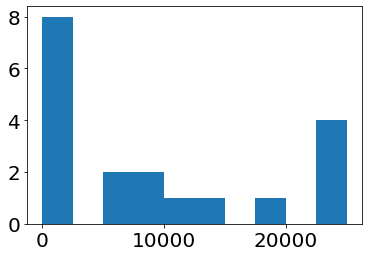

In [13]:
plt.hist(df.epochs)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


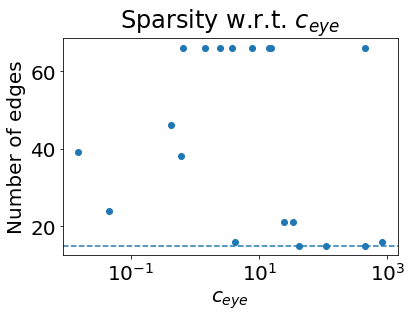

In [14]:
plt.title("Sparsity w.r.t. $c_{eye}$")
plt.scatter(df['config/_gin__eyecoeff__loguniform'], df['metrics/nnz'])
plt.xscale('log')
plt.xlabel("$c_{eye}$")
plt.ylabel("Number of edges")
plt.axhline(15, ls='--')

In [46]:
df_fine = df[df['metrics/nnz'] <= 15]

In [47]:
def find_trial(row, path=path):
    """Get folder name for a trial row."""
    trials = os.listdir(path)
    is_match = [row.trial_id in trial and row.experiment_tag in trial for trial in trials]
    assert sum(is_match) == 1
    idx = np.where(is_match)[0][0]
    trial = trials[idx]
    return trial

In [48]:
from path import Path
import gin
import sparse_causal_model_learner_rl.config
from causal_util import load_env, get_true_graph
gin.bind_parameter('Config._unpickle_skip_init', True)
gin.enter_interactive_mode()

In [49]:
trial_names = [find_trial(row) for _, row in df_fine.iterrows()]

In [51]:
class model_():
    def __init__(self, Mf, Ma):
        self.Mf = Mf
        self.Ma = Ma
        
def adhoc_model(l):
    """Get an instance with Mf, Ma attributes."""
    n_f = l._unpickled_state['config'].get('feature_shape')[0]
    if gin.query_parameter('ModelDecoder.add_batch_number'):
        n_f += 1
    fadd = l._unpickled_state['config'].get('additional_feature_keys')
    print(n_f, fadd)
    
    gin.bind_parameter('graph_for_matrices.additional_features', fadd)
    gin.bind_parameter('plot_model.vmin', 0.0)
    gin.bind_parameter('plot_model.singlecolor_palette', True)
    gin.bind_parameter('plot_model.additional_features', fadd)
    P = l._unpickled_state['trainables_weights']['model']['model.switch.probas'].T
    
    print(P.shape)
    
    Mf = P[:, :n_f].detach().cpu().numpy()
    Ma = P[:, n_f:].detach().cpu().numpy()
    model = model_(Mf, Ma)
    return model

In [52]:
def model_from_trial(trial):
    trial_path = os.path.join(path, trial)
    checkpoints = [x for x in os.listdir(trial_path) if x.startswith('checkpoint')]
    checkpoint_epochs = {x: int(x.split('_')[1]) for x in checkpoints}
    checkpoints_rev = sorted(checkpoints, key=lambda x: checkpoint_epochs[x], reverse=True)
    
    l = None
    for checkpoint in checkpoints_rev:
        print("Trying checkpoint", checkpoint)
        try:
            ckpt_path = os.path.join(trial_path, checkpoint, 'checkpoint')
            l = unpickle(ckpt_path)
#             print(gin.config_str())
            break
        except Exception as e:
            print("Can't read", checkpoint)
            
    if l is None:
        raise ValueError("No checkpoints for trial", trial)
        
    gin.parse_config(l._unpickled_state['gin_config'])
    model = adhoc_model(l)
    
    return l, model

In [53]:
from itertools import permutations
from scipy.spatial.distance import cosine

In [54]:
def permute_model(m, perm, thr=0.9):
    permuted_Mf = m.Mf[perm, :][:, perm] > thr
    permuted_Ma = m.Ma[perm, :] > thr
    return permuted_Mf, permuted_Ma

def distance(m, m_true, perm, thr=0.9):
    permuted_Mf, permuted_Ma = permute_model(m, perm, thr=thr)
    Mf_true, Ma_true = m_true.Mf > thr, m_true.Ma > thr
    
    cosF = cosine(permuted_Mf.flatten(), Mf_true.flatten())
    cosA = cosine(permuted_Ma.flatten(), Ma_true.flatten())

    cos = cosF + cosA
    return cos

In [55]:
def check_last_feature(m, thr=0.9):
    Mf = m.Mf > 0.9
    Ma = m.Ma > 0.9
    assert np.sum(Mf[-1, :-1]) == 0
    assert np.sum(Mf[:-1, -1]) == 0
    assert Mf[-1, -1] == True, Mf[-1, -1]
    assert np.sum(Ma[-1, :]) == 0

In [56]:
def visualize_trial(trial):

    l, m = model_from_trial(trial)
    check_last_feature(m)

    env = load_env()
    G = get_true_graph(env)
    m_true = model_(G.As, G.Aa)

    fig = l.visualize_model(m)
    display(fig)
    gvz_m = l.visualize_graph(model=m)[1]
    gvz_m_true = l.visualize_graph(model=m_true)[1]
    
    display(gvz_m)
    
    n_f = m.Mf.shape[0]
    perms = list(permutations(range(n_f - 1)))

    distances = [distance(m, m_true, perm) for perm in perms]
    idx = np.argmin(distances)
    print("Best cosine", distances[idx])
    print("Best permutation", perms[idx])

    best_f, best_a = permute_model(m, perms[idx])
    display(l.visualize_graph(model=model_(1. * best_f, 1. * best_a))[1])
    return distances[idx]

===== main_fcn_eb390_00000_0__gin__eyecoeff__loguniform=441.66_2021-04-15_11-49-49 ======
Trying checkpoint checkpoint_8628
6 None
torch.Size([6, 11])
Make environment SparseMatrix-v0 [<class 'encoder.observation_encoder.LinearMatrixEncoder'>] {}


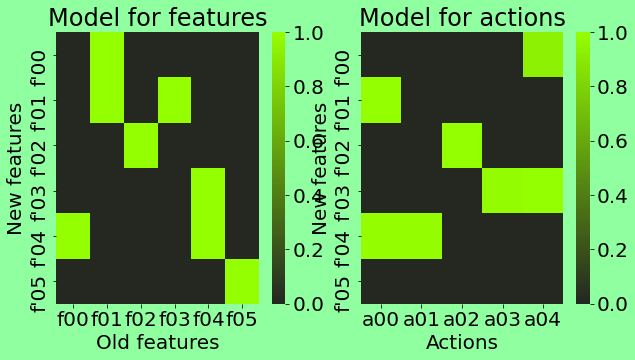

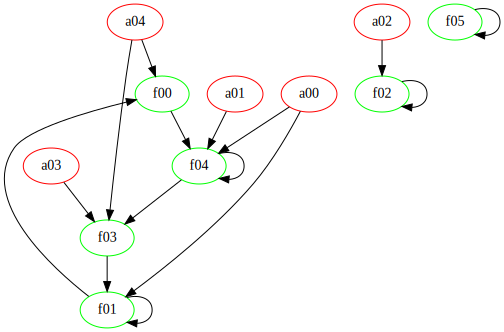

Best cosine 0.0
Best permutation (0, 3, 4, 1, 2)


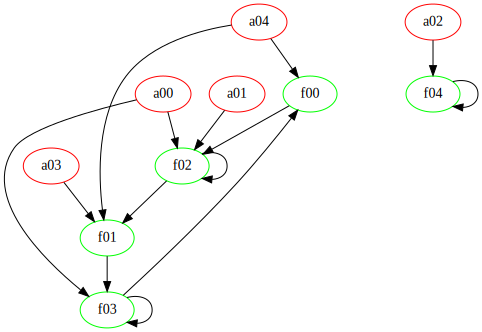

===== main_fcn_eb390_00005_5__gin__eyecoeff__loguniform=41.24_2021-04-15_22-17-46 ======
Trying checkpoint checkpoint_5651
6 None
torch.Size([6, 11])
Make environment SparseMatrix-v0 [<class 'encoder.observation_encoder.LinearMatrixEncoder'>] {}


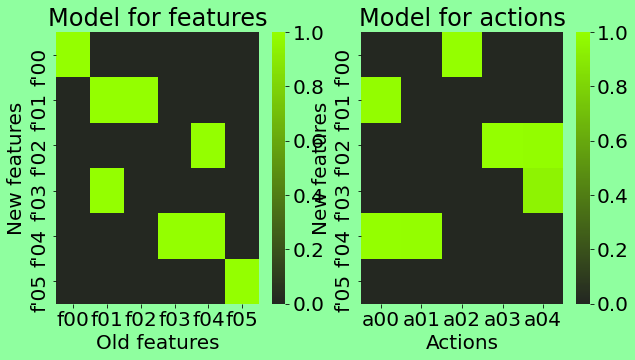

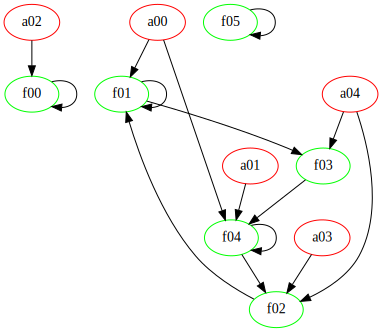

Best cosine 0.0
Best permutation (3, 2, 4, 1, 0)


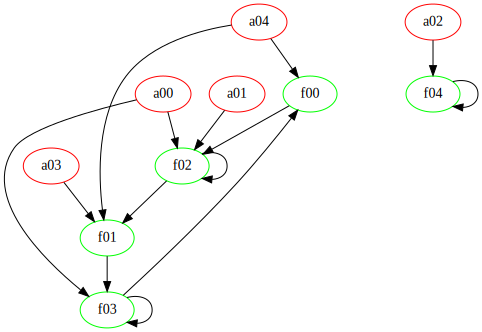

===== main_fcn_eb390_00006_6__gin__eyecoeff__loguniform=108.79_2021-04-15_22-17-46 ======
Trying checkpoint checkpoint_6713
6 None
torch.Size([6, 11])
Make environment SparseMatrix-v0 [<class 'encoder.observation_encoder.LinearMatrixEncoder'>] {}


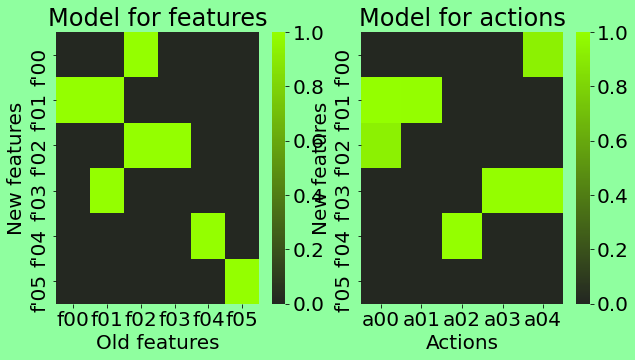

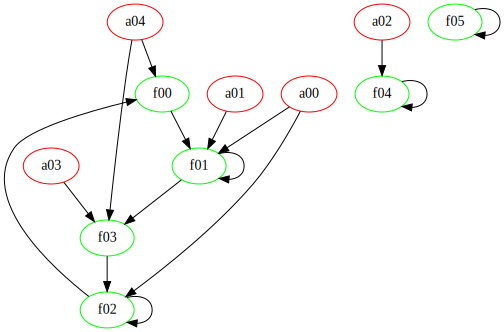

Best cosine 0.0
Best permutation (0, 3, 1, 2, 4)


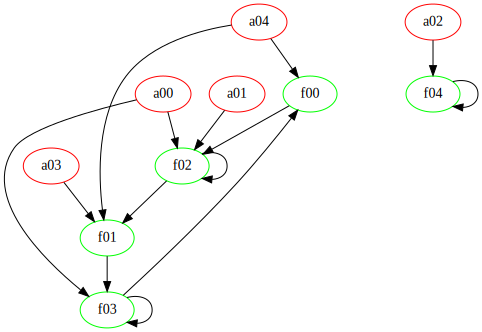

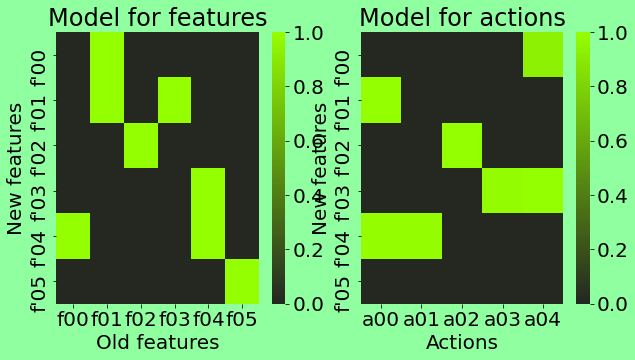

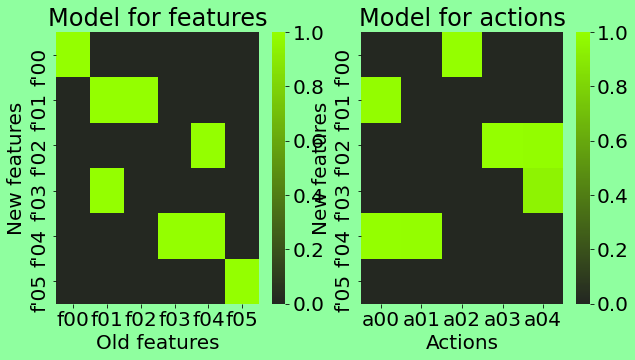

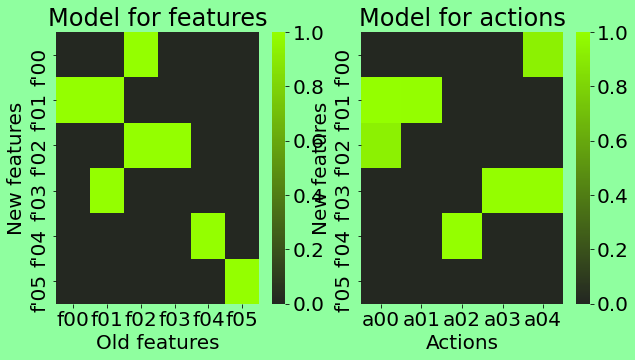

In [57]:
cosines = []
for trial in trial_names:
    print(f"===== {trial} ======")
    dst = visualize_trial(trial)
    cosines.append(dst)

(array([0., 0., 0., 0., 0., 3., 0., 0., 0., 0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

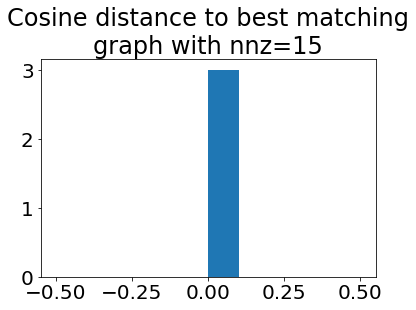

In [62]:
plt.title("Cosine distance to best matching\ngraph with nnz=15")
plt.hist(cosines)

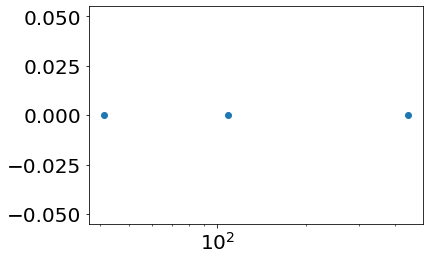

In [59]:
plt.scatter(df_fine['config/_gin__eyecoeff__loguniform'], cosines)#df['metrics/nnz']))
plt.xscale('log')

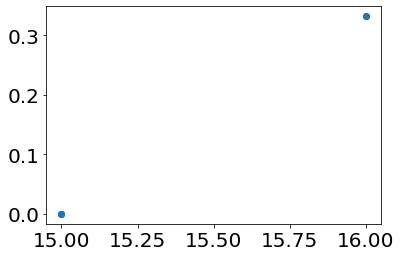

In [38]:
plt.scatter(df_fine['metrics/nnz'], cosines)

In [65]:
l, _ = model_from_trial(trial_names[0])
env = load_env()
G = get_true_graph(env)
m_true = model_(G.As, G.Aa)

Trying checkpoint checkpoint_8628
6 None
torch.Size([6, 11])
Make environment SparseMatrix-v0 [<class 'encoder.observation_encoder.LinearMatrixEncoder'>] {}


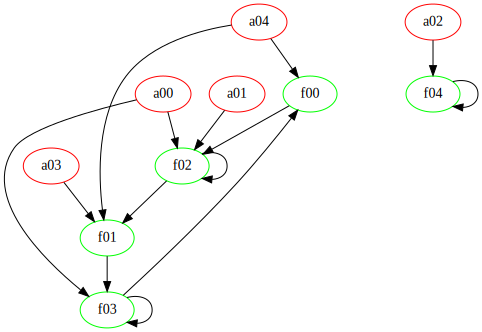

In [68]:
l.visualize_graph(model=m_true)[1]

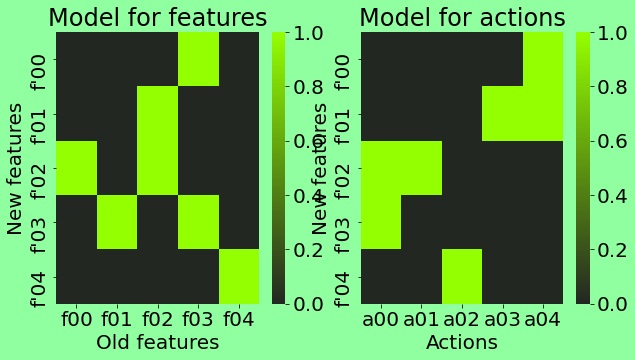

In [70]:
_ = l.visualize_model(model=m_true)

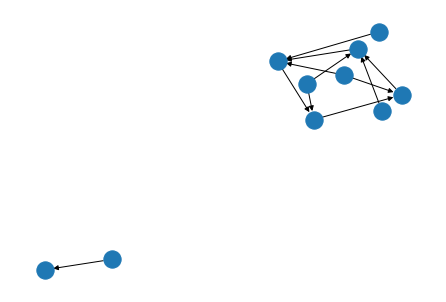

In [42]:
nx.draw(nx_m_true, pos = nx.spring_layout(nx_m_true))

In [43]:
from networkx.algorithms import isomorphism

In [49]:
match = isomorphism.GraphMatcher(nx_m, nx_m_true)

In [50]:
dir(match)

['G1',
 'G1_adj',
 'G1_nodes',
 'G2',
 'G2_adj',
 'G2_node_order',
 'G2_nodes',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'candidate_pairs_iter',
 'core_1',
 'core_2',
 'edge_match',
 'initialize',
 'inout_1',
 'inout_2',
 'is_isomorphic',
 'isomorphisms_iter',
 'mapping',
 'match',
 'node_match',
 'old_recursion_limit',
 'reset_recursion_limit',
 'semantic_feasibility',
 'state',
 'subgraph_is_isomorphic',
 'subgraph_is_monomorphic',
 'subgraph_isomorphisms_iter',
 'subgraph_monomorphisms_iter',
 'syntactic_feasibility',
 'test']

In [51]:
match.subgraph_is_isomorphic()

False